# Shock Tube

A shock tube is an idealized device that generates a one-dimensional shock wave in a compressible gas. The setting allows an analytical solution of the Euler equations, which is very useful for comparing with the numerical results to assess their accuracy.

Picture a tube with two regions containing gas at different pressures, separated by an infinitely-thin, rigid diaphragm. The gas is initially at rest, and the left region is at a higher pressure than the region to the right of the diaphragm. At time $t=0s$, the diaphragm is ruptured instantaneously. 

What happens?

You get a shock wave. The gas at high pressure, no longer constrained by the diaphragm, rushes into the lower-pressure area and a one-dimensional unsteady flow is established, consisting of:

* A Shock wave traveling to the right.
* An expansion wave traveling to the left
* A moving contact discontinuity.

The shock-tube problem is an example of a Riemann problem and it has an analytical solution, as we said. The situation is illustrated in the next figure.

<img src="Figure-2.png">

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import njit
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

## The Euler equations

The Euler equations govern the motion of an inviscid fluid (no viscosity). They consist of the conservation laws of mass and momentum, and often we also need to work with the energy equation.

Let's consider a 1D flow with velocity $u$ in the $x$ direction. The Euler equations for a fluid with density $\rho$ and pressure $p$ are:

\begin{equation}
\frac{\partial \rho}{\partial t}+\frac{\partial}{\partial x}(\rho u)=0 \\
\frac{\partial}{\partial}(\rho u)+\frac{\partial}{\partial x}(\rho u^2+p)=0
\end{equation}

plus the energy equation, which we can write in this form:

\begin{equation}
\frac{\partial}{\partial t}(\rho E_T)+\frac{\partial}{\partial x}(\rho uE_T+pu)=0
\end{equation}

where $E_T=E+\frac{u^2}{2}$ is the total energy per unit mass, equal to the internal energy plus the kinetic energy (per unit mass).

Written in vector form, you can see that the Euler equations bear a strong resemblance to the traffic-density equation that has been the focus of this course module so far. Here is the vector representation of the Euler equation:

\begin{equation}
\frac{\partial}{\partial t}\underline{u}+\frac{\partial}{\partial x}\underline{\text{f}}=0
\end{equation}

## The conservative form

Many works in the early days of computational fluid dynamics in the 1960s showed that using the conservation form of the Euler equations is more accurate for situations with shock waves. And as you already saw, the shock-tube solutions do contain shocks.

The conserved variables $\underline{u}$ for Euler's equations are:

\begin{equation}
\underline{u}=\begin{bmatrix} \rho \\ \rho u\\ \rho E_T \end{bmatrix}
\end{equation}

where $\rho$ is the density of the fluid, $u$ is the velocity of the fluid and $E_T=E+\frac{u^2}{2}$ is the specific total energy: $\underline{\text{f}}$ is the flux vector:

\begin{equation}
\underline{\text{f}}=\begin{bmatrix} \rho u \\ \rho u^2+p\\ (\rho E_T+p)u \end{bmatrix}
\end{equation}

where $p$ is the pressure of the fluid. 

If we put together the conserved variables and the flux vector into our PDE, we get the following set of equations:

\begin{equation}
\frac{\partial}{\partial t}\begin{bmatrix} \rho \\ \rho u\\ \rho E_T \end{bmatrix}+\frac{\partial}{\partial x}\begin{bmatrix} \rho u \\ \rho u^2+p\\ (\rho E_T+p)u \end{bmatrix}=0
\end{equation}

There's one major problem there. We have 3 equations and 4 unknowns. But there is a solution! We can use an equation of state top calculate the pressure -in this case, we'll use the ideal gas law.

## Calculating the pressure

For an ideal gas, the equation of state is:

\begin{equation}
E=E(\rho,p)=\frac{p}{(\gamma-1)\rho}
\end{equation}

where $\gamma=1.4$ is a reasonable value to model air, 

\begin{equation}
\therefore p=(\gamma-1)\rho E
\end{equation}

Recall from above that $E_T=E+\frac{1}{2}u^2$,

\begin{equation}
\therefore E=E_T-\frac{1}{2}u^2
\end{equation}

Putting it all together, we arrive at an equation for the pressure

\begin{equation}
p=(\gamma-1)\left(\rho E_T-\frac{\rho u^2}{2}\right)
\end{equation}

## Flux in terms of $\underline{u}$

With the traffic model, the flux was a function of traffic density. For the Euler equations, the three equations we have are coupled and the flux vector is a function of $\underline{u}$, the vector of conserved variables:

\begin{equation}
\underline{\text{f}}=f(\underline{u})
\end{equation}

In order to get everything squared away, we need to represent $\underline{\text{f}}$ in terms of $\underline{u}$. We can introduce a little shorthand for the $\underline{u}$ and $\underline{f}$ vectors and define:

\begin{equation}
\underline{u}=\begin{bmatrix} u_1 \\ u_2 \\ u_3 \end{bmatrix} = \begin{bmatrix} \rho \\ \rho u \\ \rho E_T \end{bmatrix} \\
\end{equation}

\begin{equation}
\underline{\text{f}}=\begin{bmatrix} f_1 \\ f_2 \\ f_3 \end{bmatrix} = \begin{bmatrix} \rho u \\ \rho u^2+p \\ (\rho E_T+p)u \end{bmatrix}
\end{equation}

With a little algebraic trickery, we can represent the pressure vector using wuantities from the $\underline{u}$ vector. 

\begin{equation}
p=(\gamma - 1)\left(u_3-\frac{1}{2}\frac{u_2^2}{u_1}\right)
\end{equation}

Now that pressure can be represented in terms of $\underline{u}$, the rest of $\underline{\text{f}}$ isn't too difficult to resolve:

\begin{equation}
\underline{\text{f}}=\begin{bmatrix} f_1 \\ f_2 \\ f_3 \end{bmatrix} = \begin{bmatrix} u_2 \\ \frac{u_2^2}{u_1}+(\gamma-1)\left(u_3-\frac{1}{2}\frac{u_2^2}{u_1}\right) \\ \left(u_3+(\gamma-1)\left(u_3-\frac{1}{2}\frac{u_2^2}{u_1}\right)\right)\frac{u_2}{u_1} \end{bmatrix}
\end{equation}

## The Richtmyer method

For this exercise, i'll be using the new scheme called **The Richtmyer method**. This is a **two-step** method (such as the MacCormack method). This is given by:

\begin{equation}
\underline{u}_{i+\frac{1}{2}}^{j+\frac{1}{2}}=\frac{1}{2}(\underline{u}_{i+1}^j+\underline{u}_i^j)-\frac{\Delta t}{2\Delta x}(\underline{\text{f}}_{i+1}^j-\underline{f}_i^j) \\
\\
u_i^{j+1}=u_{i}^j-\frac{\Delta t}{\Delta x}\left(\underline{\text{f}}_{i+\frac{1}{2}}^{j+\frac{1}{2}}-\underline{\text{f}}_{i-\frac{1}{2}}^{j+\frac{1}{2}}\right)
\end{equation}

The flux vectors used in the second step are obtained by evaluating the flux functions on the output of the first step:

\begin{equation}
\underline{\text{f}}_{i+\frac{1}{2}}^{j+\frac{1}{2}}=\underline{\text{f}}\left(\underline{u}_{i+\frac{1}{2}}^{j+\frac{1}{2}}\right)
\end{equation}

The first step is like a **predictor** of the solution. If you look closely, you'll see that we are applying a Lax-Friedrichs scheme here. The second step is a corrector that applies a leapfrog update.

## Sod's Shock Tube

in brief, you are given the following coupled partial differential equations:

\begin{equation}
\frac{\partial}{\partial t}\begin{bmatrix} \rho \\ \rho u\\ \rho E_T \end{bmatrix}+\frac{\partial}{\partial x}\begin{bmatrix} \rho u \\ \rho u^2+p\\ (\rho E_T+p)u \end{bmatrix}=0
\end{equation}

Picture a tube spanning from $x=-10$m to $x=10$m with the rigid membrane at $x=0$m

\begin{equation}
\underline{IC}_L=\begin{pmatrix} \rho_L \\ u_L \\ p_L \end{pmatrix} = \begin{pmatrix} \text{1 } kg/m^3 \\ \text{0 } m/s \\ \text{100 } kN/m^2 \end{pmatrix}
\end{equation}

\begin{equation}
\underline{IC}_R=\begin{pmatrix} \rho_R \\ u_R \\ p_R \end{pmatrix} = \begin{pmatrix} \text{0.125 } kg/m^3 \\ \text{0 } m/s \\ \text{10 } kN/m^2 \end{pmatrix}
\end{equation}

where $\underline{IC}_L$ are the initial density, velocity and pressure on the left side of the tube membrane and $\underline{IC}_R$ are the initial density, velocity and pressure on the right side of the tube membrane. At time $t=0s$, the membrane is instantaneously removed.

For the purposes of this exercise, assumre the initial conditions apply as follows:

\begin{equation}
\underline{IC}_L\text{ for }-10\leq x<0 \\
\underline{IC}_R\text{ for }0\leq x\leq 10
\end{equation}

Calculate the pressure, density and velocity across the shock tube at time $t=0.01s$ using the Ricthmyer method using the following code parameters:

* $Nx$=81
* $\Delta x$=0.25 
* $\Delta t$=0.0002
* $\gamma$=1.4

In [148]:
#---------------#
# Parameters    #
#---------------#
Nx=81   #Grid points for x
dx=0.25 #Spatial x
dt=0.0002 #Spatial t
gamma=1.4 #Value for gamma

#--------------#
# Time and x   #
#--------------#
x0=-10
xf=10   #Final value for x
tf=0.01  #Final value for t
Nt=int(tf/dt+1)
#Arrays for x and t
x=np.linspace(x0,xf,Nx)
t=np.linspace(0,tf,Nt)

@njit()
def IC(Nx,Nt,x):
    #-----------------------------------------------#
    # This function put the IC in our system.       #
    # Here it is created the array for rho,p and u. #
    #-----------------------------------------------#
    rho=np.zeros((Nx,Nt))
    u=np.zeros((Nx,Nt))
    p=np.zeros((Nx,Nt))
    for i in range(Nx):
        if (x[i]<0):
            rho[i,0]=1     #rho_L in kg/m^3
            u[i,0]=0       #u_L in m/s
            p[i,0]=100000  #p_L in N/m^2
        else:
            rho[i,0]=0.125 #rho_R in kg/m^3
            u[i,0]=0       #u_R in m/s
            p[i,0]=10000   #p_R in N/m^2
    
    return rho,u,p

I'll create a function that calculate $u_1,u_2$ and $u_3$. This function it will be called u_matrix.

In [20]:
@njit()
def u_matrix(rho,u,Et):
    #----------------------------------#
    # This function solve the matrix u #
    # and create u1, u2 and u3.        #
    #----------------------------------#
    u1=rho         #The first value
    u2=rho*u       #The second value
    u3=rho*Et      #The third value
    u=[u1,u2,u3]

    return u       #Return the matrix u

Also, i create the following function to calculate the terms of $\underline{\text{f}}$

In [21]:
@njit()
def f_matrix(u1,u2,u3,gamma):
    #--------------------------------#
    # This function calculates the   #
    # terms for the flux vector      #
    #--------------------------------#
    f1=u2
    f2=((u2**2)/u1)+(gamma-1)*(u3-0.5*((u2**2)/u1))
    f3=(u3+(gamma-1)*(u3-0.5*((u2**2)/u1)))*(u2/u1)
    f=[f1,f2,f3]
    
    return f    #Return the matrix f

In [22]:
@njit()
def u_instance(i,u):
    #-----------------------------#
    # This function only works to #
    # calculate the momentary u1, #
    # u2 and u3 for a instant i.  #
    #-----------------------------#
    u1=u[0][i]
    u2=u[1][i]
    u3=u[2][i]

    return [u1,u2,u3]


@njit()
def f_instance(i,f):
    #-------------------------#
    # This function gives the #
    # momentary f1, f2 and f3 #
    # for a instant i.        #
    #-------------------------#
    f1=f[0][i]
    f2=f[1][i]
    f3=f[2][i]

    return [f1,f2,f3]

Now, I create the function that put all together and solve the system.

In [103]:
@njit()
def sod_shock(Nx,Nt,x,gamma,dx,dt):
    #------------------------------#
    # This function calculate the  #
    # sod shock tube problem using #
    # the Richtmyer method.        #
    #------------------------------#
    rho,u,p=IC(Nx,Nt,x)  #Create the arrays for rho,u and p

    #----------#
    # Energy   #
    #----------#
    E=np.zeros((Nx,Nt))  #Create the matrix for the internal energy
    Et=np.zeros((Nx,Nt)) #Create the matrix for the total energy
    E[:,0]=p[:,0]/((gamma-1)*rho[:,0]) #Initial internal energy
    Et[:,0]=E[:,0]+0.5*u[:,0]**2       #Initial total energy

    #----------------------------------------#
    # Uses Richtmyer method to solve the PDE #
    #----------------------------------------#
    for j in range(Nt-1):
        u_vec=u_matrix(rho[:,j],u[:,j],Et[:,j])


        f=f_matrix(u_vec[0],u_vec[1],u_vec[2],gamma)
        for i in range(Nx):
            #Values for u
            if i==Nx-1:
                u_1i=u_instance(i-1,u_vec)
                f_1i=f_instance(i-1,f)
            else:
                u_1i=u_instance(i+1,u_vec)
                f_1i=f_instance(i+1,f)

            u_2i=u_instance(i,u_vec)
            f_2i=f_instance(i,f)

            if i==0:
                u_3i=u_instance(i+1,u_vec)
                #u_3i=[-value for value in u_3i]
                f_3i=f_instance(i+1,f)
                #f_3i=[-value for value in f_3i]
            else:
                u_3i=u_instance(i-1,u_vec)
                f_3i=f_instance(i-1,f)

            u_step1=np.zeros(3)
            u_step2=np.zeros(3)
            for k in range(3):
                #The step for i+1/2
                P1=0.5*(u_1i[k]+u_2i[k])
                P2=(dt/(2*dx))*(f_1i[k]-f_2i[k])
                u_step1[k]=P1-P2
                #The step for i-1/2
                P1=0.5*(u_2i[k]+u_3i[k])
                P2=(dt/(2*dx))*(f_2i[k]-f_3i[k])
                u_step2[k]=P1-P2
            
            #Calculate f for j+1/2
            f_step1=f_matrix(u_step1[0],u_step1[1],u_step1[2],gamma)
            f_step2=f_matrix(u_step2[0],u_step2[1],u_step2[2],gamma)

            #Now, calculate u for j+1
            u_sol=np.zeros(3)
            for k in range(3):
                u_sol[k]=(u_instance(i,u_vec)[k]-(dt/dx)*(f_step1[k]-f_step2[k]))
            


            #---------------------------------------#
            # Calculate rho, u, p, E and Et for j+1 #
            #---------------------------------------#
            rho[i,j+1]=u_sol[0]
            u[i,j+1]=u_sol[1]/rho[i,j+1]
            p[i,j+1]=(gamma-1)*(u_sol[2]-0.5*(u_sol[1]**2/u_sol[0]))
            E[i,j+1]=p[i,j+1]/((gamma-1)*rho[i,j+1]) 
            Et[i,j+1]=E[i,j+1]+0.5*u[i,j+1]**2 

    return rho,u,p,Et

In [149]:
%time rho,u,p,Et=sod_shock(Nx,Nt,x,gamma,dx,dt)

CPU times: user 38.4 ms, sys: 0 ns, total: 38.4 ms
Wall time: 49.1 ms


Plot the results. My plot is distance vs $\rho, u$ and $p$.

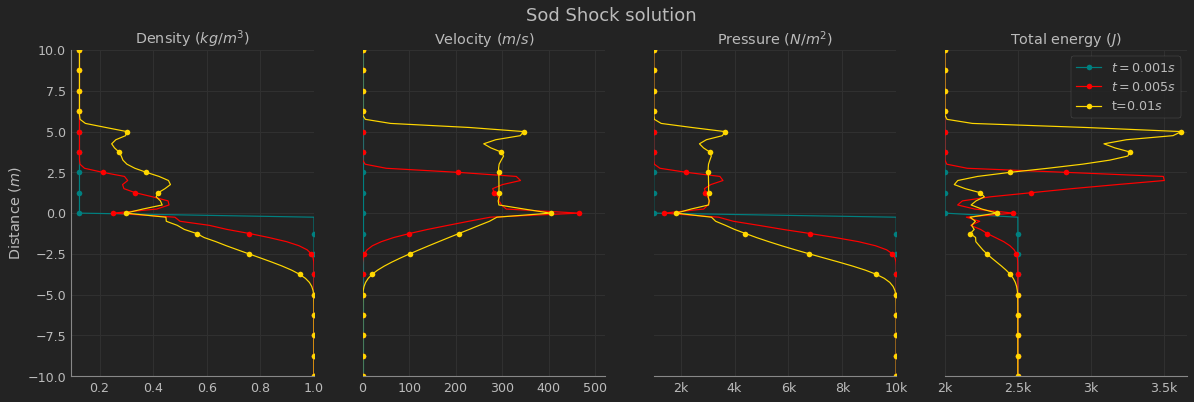

In [147]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(20,6),sharey=True)
fig.suptitle('Sod Shock solution',fontsize=18)
#---------------------#
# First plot: Density #
#---------------------#
plot1_t1=ax1.plot(rho[:,0],x, color='teal', marker='o',markevery=5)
plot1_t2=ax1.plot(rho[:,int((Nt-1)/2)],x, color='red', marker='o',markevery=5)
plot1_t3=ax1.plot(rho[:,Nt-1],x, color='gold', marker='o',markevery=5)
ax1.set_ylabel('Distance ($m$)')
ax1.set_title('Density ($kg/m^3$)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(rho.min()-0.03,rho.max())
ax1.set_ylim(x.min(),x.max())

#-----------------------#
# Second plot: Velocity #
#-----------------------#
plot2_t1=ax2.plot(u[:,0],x, color='teal', marker='o',markevery=5)
plot2_t2=ax2.plot(u[:,int((Nt-1)/2)],x, color='red', marker='o',markevery=5)
plot2_t3=ax2.plot(u[:,Nt-1],x, color='gold', marker='o',markevery=5)
ax2.set_title('Velocity ($m/s$)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(u.min(),u.max())
ax2.set_ylim(x.min(),x.max())

#----------------------#
# Third plot: Pressure #
#----------------------#
plot3_t1=ax3.plot(p[:,0],x, color='teal', marker='o',markevery=5)
plot3_t2=ax3.plot(p[:,int((Nt-1)/2)],x, color='red', marker='o',markevery=5)
plot3_t3=ax3.plot(p[:,Nt-1],x, color='gold', marker='o',markevery=5)
ax3.set_title('Pressure ($N/m^2$)')
ax3.set_xticks([20000,40000,60000,80000,100000])
ax3.set_xticklabels(['2k','4k','6k','8k','10k'])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_xlim(p.min(),p.max())
ax3.set_ylim(x.min(),x.max())

#---------------------------#
# Fourth plot: Total energy #
#---------------------------#
plot4_t1=ax4.plot(Et[:,0],x, color='teal', marker='o',markevery=5, label='$t=0.001s$')
plot4_t2=ax4.plot(Et[:,int((Nt-1)/2)],x, color='red', marker='o',markevery=5, label='$t=0.005s$')
plot4_t3=ax4.plot(Et[:,Nt-1],x, color='gold', marker='o',markevery=5, label='t=$0.01s$')
ax4.set_title('Total energy ($J$)')
ax4.set_xticks([200000,250000,300000,350000])
ax4.set_xticklabels(['2k','2.5k','3k','3.5k'])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_xlim(Et.min(),Et.max())
ax4.set_ylim(x.min(),x.max())
ax4.legend()
#plt.savefig('Sod.png')

In [151]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(20,6),sharey=True)
#fig.suptitle('Sod Shock solution',fontsize=18)
#---------------------#
# First plot: Density #
#---------------------#
line1,=ax1.plot([],[], color='teal', marker='o',markevery=5)
ax1.set_ylabel('Distance ($m$)')
ax1.set_title('Density ($kg/m^3$)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(rho.min()-0.03,rho.max())
ax1.set_ylim(x.min(),x.max())

#-----------------------#
# Second plot: Velocity #
#-----------------------#
line2,=ax2.plot([],[], color='red', marker='^',markevery=5)
ax2.set_title('Velocity ($m/s$)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(u.min(),u.max())
ax2.set_ylim(x.min(),x.max())

#----------------------#
# Third plot: Pressure #
#----------------------#
line3,=ax3.plot([],[], color='gold' ,marker='D',markevery=5)
ax3.set_title('Pressure ($N/m^2$)')
ax3.set_xticks([20000,40000,60000,80000,100000])
ax3.set_xticklabels(['2k','4k','6k','8k','10k'])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_xlim(p.min(),p.max())
ax3.set_ylim(x.min(),x.max())

#---------------------------#
# Fourth plot: Total energy #
#---------------------------#
line4,=ax4.plot([],[], color='green' ,marker='p',markevery=5)
ax4.set_title('Total energy ($J$)')
ax4.set_xticks([200000,250000,300000,350000])
ax4.set_xticklabels(['2k','2.5k','3k','3.5k'])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_xlim(Et.min(),Et.max())
ax4.set_ylim(x.min(),x.max())

def animate(i):
    global x,rho,u,p,Et,t
    line1.set_data(rho[:,i],x)
    line2.set_data(u[:,i],x)
    line3.set_data(p[:,i],x)
    line4.set_data(Et[:,i],x)
    fig.suptitle('Sod Shock solution at t={0:.3f}s'.format(t[i]))
    return line1,line2,line3,line4

anim=FuncAnimation(fig,animate,frames=Nt,interval=30,blit=True)
plt.close()
%time anim.save('sod.mp4',fps=15)

CPU times: user 24.3 s, sys: 686 ms, total: 25 s
Wall time: 26.1 s
